# **Arabic Language Natural Language Processing**
## In this project, I use a collection of tweets to demonsrate basic steps in processing Arabic. I clean the text, tokenize it, lemmatize it, and plot a Word Cloud as well as the most frequent words.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install camel pyarabic qalsadi arabic_reshaper

In [ ]:
# Load dependancies
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import spacy
import camel
import re
from nltk.corpus import stopwords
import requests
import qalsadi.lemmatizer
from collections import Counter
import plotly.express as px
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
# Arabic display with Wordcloud
import arabic_reshaper
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
# File directory
file_dir = '/content/gdrive/MyDrive/NLP/Assignment 1/file1.txt'

### **Preprocessing**

In [5]:
# Read and process tweets
def process_tweets(text_file):
  df = pd.read_csv(file_dir, sep='\t')
  df = df.drop(['tweetID'],axis=1)
  tweets = list(df['tweetText'])
  return tweets

In [6]:
# Define stop words
# Source for Arabic stop words: https://github.com/mohataher/arabic-stop-words/
url = "https://raw.githubusercontent.com/mohataher/arabic-stop-words/master/list.txt"
ar_stopwords = requests.get(url).text.splitlines()
en_stopwords = stopwords.words('english')
stopwords = ar_stopwords + en_stopwords

In [7]:
# Clean text
def clean_text(text):
    # Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra white space
    text = re.sub(r'\s+', ' ', text).strip()
    return text
# Tokenize
def tokenize(text, pattern=r'\w+'):
    # Use the findall() function to extract all matches of the pattern in the text
    tokens = re.findall(pattern, text)
    return tokens

# Remove stop words
def remove_stopwords(tokenized_text):
  # Keeps words that are not included in the list of stop words
  cleaned = [token for token in tokenized_text if token not in stopwords]
  return cleaned

# Lemmatize
def lemmatize(tokenized_text):
  lemmatized_text = ' '.join(tokenized_text)
  lemmer = qalsadi.lemmatizer.Lemmatizer()
  lemmatized = lemmer.lemmatize_text(lemmatized_text)
  return lemmatized

In [8]:
# Process text (Clean, tokenize and remove stop words)
def text_processing(text):
 text = text
 text = clean_text(text)
 text = tokenize(text)
 text = remove_stopwords(text)
 # uncomment to lemmatize
 # text = lemmatize(text) 
 return text

In [9]:
# Wrapper Function to Process Tweets
def process(file_path):
  tweets = process_tweets(file_path)
  tweets = [text_processing(tweet) for tweet in tweets]
  return tweets
processed_tweets = process(file_dir)

### **Basic Explaratory Data Analysis and Vizaualization**

In [10]:
# Token Counts
def count_tokens(tweets):
  """
  This function takes a list of tokenized tweets and counts the frequency of each token.
  It then creates a pandas DataFrame with two columns: "token" and "count", where the "token" column contains the unique tokens and the "count" column contains their corresponding frequency counts.
  The DataFrame is sorted in descending order by the token count.

  Parameters:
  - tweets: A list of lists, where each inner list contains the tokens of a single tweet.

  Returns:
  - A pandas DataFrame with two columns: "token" and "count", where the "token" column contains the unique tokens and the "count" column contains their corresponding frequency counts.
  """

  # Flatten the list of lists into a single list
  flat_list = [token for tweet in tweets for token in tweet]
  # Count the frequency of each token using a Counter object
  token_counts = Counter(flat_list)
  # Create a pandas DataFrame with two columns: "token" and "count"
  df = pd.DataFrame({'token': list(token_counts.keys()), 'count': list(token_counts.values())})
  df = df.sort_values('count',ascending=False)
  return df
token_count = count_tokens(processed_tweets)

In [11]:
# Histogram of Word Freqnuencies 
def plot_freq(freq_df,freq):
  """
    Plots a horizontal histogram of the top 'freq' most frequent words in the input DataFrame.

    Parameters:
    freq_df (DataFrame): a pandas DataFrame containing two columns ('token' and 'count') representing word frequencies.
    freq (int): the number of most frequent words to plot.

    Returns:
    None (displays the plot in the default browser).
  """

  # Sort the input DataFrame by count in descending order and select the top 'freq' rows.
  freq_df = freq_df.sort_values('count',ascending=False).iloc[:freq]
  # Create a horizontal histogram plot using Plotly Express.
  fig = px.histogram(freq_df, 
                   x='count',
                   y='token',
                   orientation='h',
                   template = 'plotly_white',
                   color='token')
  # Update the plot title, axis labels, size, and other layout parameters.
  fig.update_layout(title=f'Top {freq} Most Frequent Words', 
                    xaxis_title='Frequency', 
                    yaxis_title='Word', 
                    width=800, 
                    height=800,
                    showlegend=False)
  # Reverse the y-axis values to display the most frequent words at the top.
  fig.update_yaxes(autorange="reversed")
  fig.show()

plot_freq(token_count,100)

In [12]:
# Most Frequent Word
print(f"Most Frequent Word: {list(token_count.iloc[0,:])[0]} mentioned {list(token_count.iloc[0,:])[1]} times.")

Most Frequent Word: سوني mentioned 689 times.


In [13]:
# Retrieve Frequency of a Word
def get_freq(word,freq_df):
  freq = token_count[token_count['token']==word]
  print(f"The frequency of {freq['token'].values[0]} is {freq['count'].values[0]}")
get_freq('سوني',token_count)

The frequency of سوني is 689


### **Word Cloud**

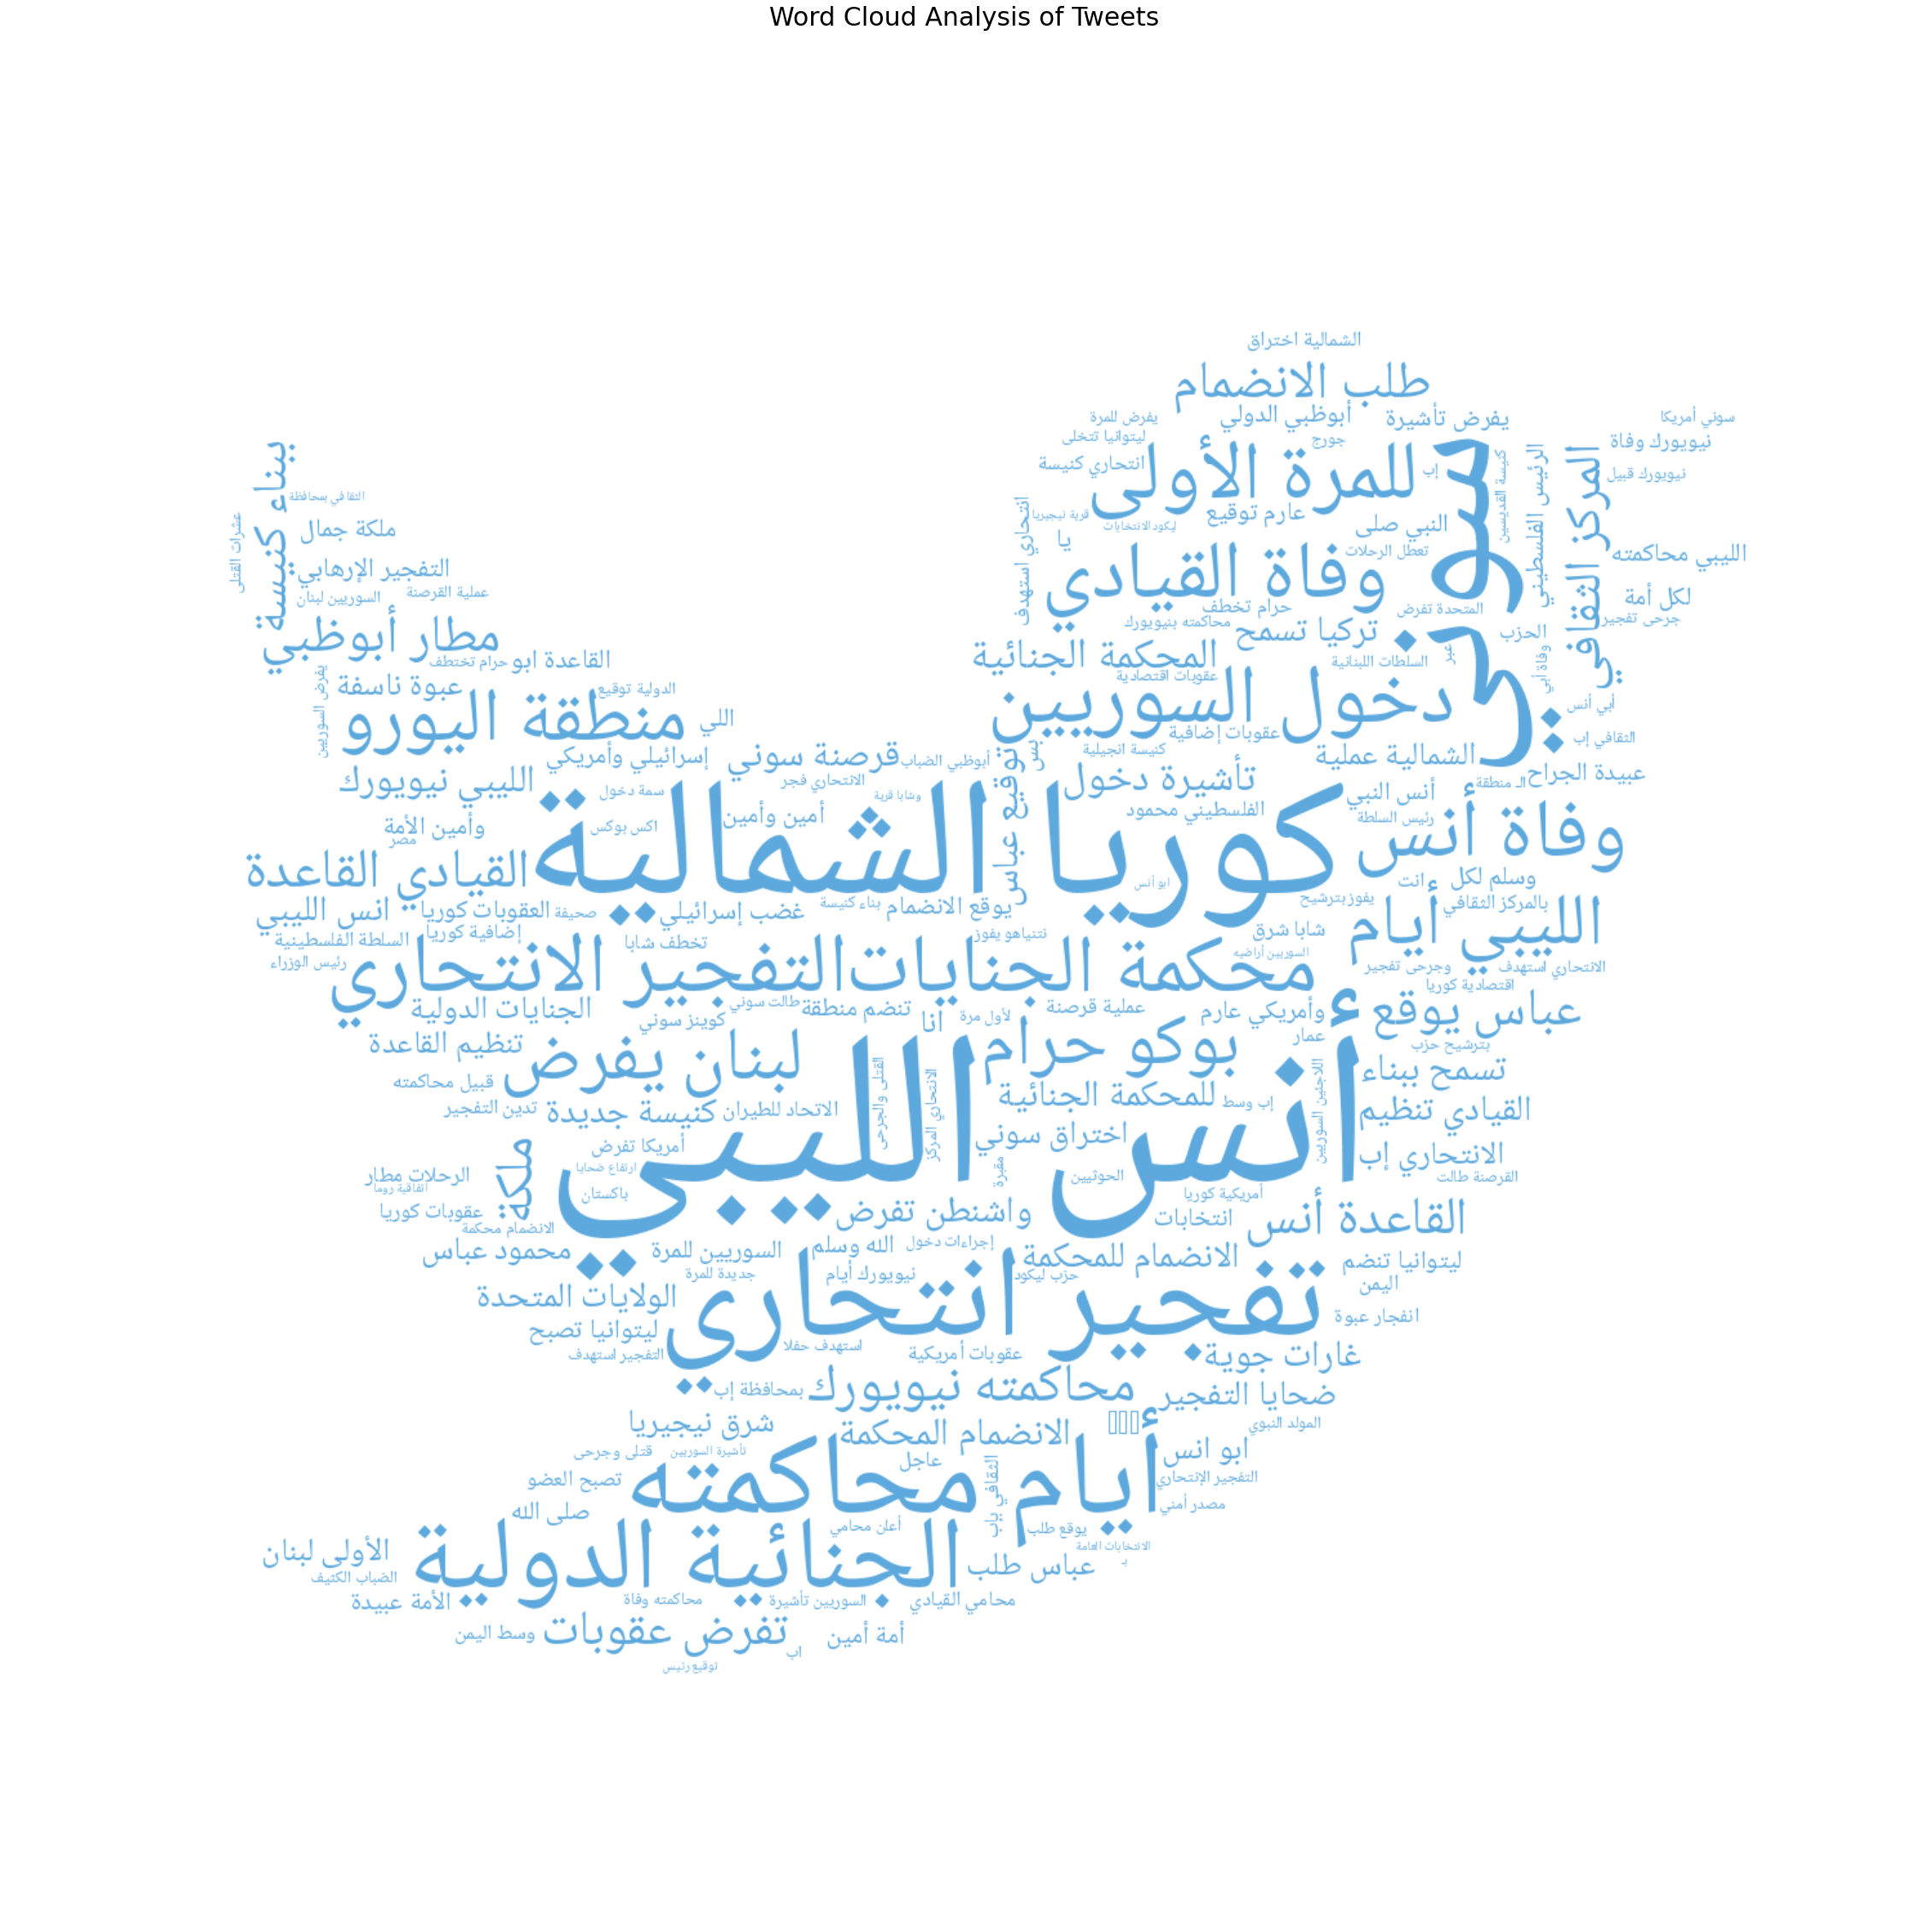

In [14]:
# Plot word cloud
# Load mask
mask_image = Image.open("/content/gdrive/MyDrive/NLP/Assignment 1/twitter.jpg").convert('L')
mask_array = np.array(mask_image)
# Generate color
color = np.array(Image.open("/content/gdrive/MyDrive/NLP/Assignment 1/color.png"))
image_colors = ImageColorGenerator(color)
# Generate words for cloud
flat_list = [token for tweet in processed_tweets for token in tweet]
words = ' '.join(flat_list)
# Process Arabic text
words = arabic_reshaper.reshape(words)
# Generate word cloud
font = '/content/gdrive/MyDrive/NLP/Assignment 1/NotoNaskhArabic-Regular.ttf'
wc = WordCloud(width=800, 
               height=400, 
               background_color='white', 
               mask=mask_array,
               font_path=font).generate(words)
wc.recolor(color_func=image_colors)
# Plot word cloud
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(32,32))
fig.set_facecolor('white')
fig.suptitle('Word Cloud Analysis of Tweets', fontsize=30)
axs.imshow(wc, interpolation='bilinear')
axs.axis('off')
plt.tight_layout()
plt.savefig('arabic_tweets_word_cloud.jpg', dpi=300)
plt.show()